In [1]:
#@title Imports
import json
from json import JSONDecodeError
import itertools

import urllib
import string
import re
from itertools import chain

import re

from transformers import AutoTokenizer
import tensorflow as tf
from transformers import TFAutoModel

from numpy import dot
from numpy.linalg import norm

import tensorflow as tf
from transformers import TFAutoModel, TFBertTokenizer

import scipy
import random
from random import shuffle
import numpy as np

from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, StringLookup
from keras.optimizers import Adagrad
tf.debugging.disable_traceback_filtering()

import itertools
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import json

#@title Load links
def load_links():
    users_filename = '/tf/content/links.jsonl'                                                                                                    
    with open(users_filename, 'r') as posts_file:                                                                                            
        links = []
        lines = posts_file.readlines()                                                                                                       
        for line in lines:
            links.append(json.loads(line))                                                                                                    
        return links


links = load_links()
links = dict([(link['url'], link) for link in links])

In [4]:
#@title Stream Reading Func

#%%file load_posts.py
# %%timeit
# https://towardsdatascience.com/data-formats-for-training-in-tensorflow-parquet-petastorm-feather-and-more-e55179eeeb72
# https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3
import json
from json import JSONDecodeError
import itertools

def iterate_posts(posts_filename='/tf/content/posts5_souped.txt', language='en'):
  with open(posts_filename, 'r', buffering=-1) as posts_file:
    line = posts_file.readline()
    while line:
      line = posts_file.readline()
      try:
        post = json.loads(line)
        if not language or language != post['language']:
          continue
        yield post
      except JSONDecodeError:
        #print('Error, skipping line: %s' % line)
        pass
    
    posts_file.close()

for idx, p in enumerate(iterate_posts()):
  if idx >= 1_000:
    break

post_sample = list(itertools.islice(iterate_posts(), 1000))

In [5]:
#@title Process URL / Link info
import urllib
import string
import re
from itertools import chain

# Ref: https://macxima.medium.com/python-extracting-urls-from-strings-21dc82e2142b
#link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)

# Ref: https://stackoverflow.com/questions/839994/extracting-a-url-in-python
link_regex = re.compile('(?P<url>https?://[^\s]+)')

def keep_netloc_part(s):
  return (
      len(s) > 1 and
      s != 'www'
  )


def keep_path_parts(s):
  return (
      len(s) > 1 and
      s != 'tags' and 
      not s.isnumeric() and
      not all(c in string.hexdigits for c in s) and
      any(c in 'aeiouy' for c in s)
  )


def url_to_informative_string(url):
  if not url: return ''

  try:
    parsed_url = urllib.parse.urlparse(url)
  except:
    return ''
  
  netloc_parts = parsed_url.netloc.split('.')[:-1] # skip top-level domain
  netloc_parts = filter(keep_netloc_part, netloc_parts)

  path_parts = re.split('/|-|\.|@', parsed_url.path)
  path_parts = filter(keep_path_parts, path_parts)
  
  # includes unique end sentinel to give the transformer an opportunity
  # to treat the  url parts specially from the other text in the post
  return (
      ' '.join(chain(netloc_parts, path_parts)) +
      '. '
  )

def urls_from_post(post):
  content = post['content']
  content = content.replace('http', ' http')

  urls = post['first_link_url']
  urls = [urls] if urls else list()
  urls.extend(re.findall(link_regex, content))
  
  return urls


def transform_urls_in_content(content, urls):
  transformed_urls = [url_to_informative_string(u) for u in urls]

  for url, transformed_url in zip(urls, transformed_urls):
    content = content.replace(url, transformed_url)
  return content


def content_from_post_with_link_info(post):
  content, urls = post['content'], urls_from_post(post)
  content = transform_urls_in_content(content, urls)

  for url in urls:
    link = links.get(url)
    if not link:
      continue
    # Note truncation here, could be improved by using tfidf to find
    # useful sentences insead...
    if title := link['og:title']:
      content += title[0:4096]
    if description := link['og:description']:
      content += description[0:4096]
    
    # include an ending sentinel
    content += '. '
  
  return content


max_len = 0
for idx, post in enumerate(iterate_posts()):
  content = content_from_post_with_link_info(post)
  max_len = max(max_len, len(content))
  # print('---------------')
  # print(content)

  if 0 == idx % 10_000:
    print(max_len)
    max_len = 0

  if idx > 100_000:
    break

print(max_len)

164
4150
8556
4873
8399
5016
5935
6566
4311
6192
8748
129


In [6]:
#@title Index posts by tag
import re

hashtag_regex = r'\#([\w.-]+)'
def tag_list_from_string(s):
  return re.findall(hashtag_regex, s)

def tag_list_from_post(p):
  return tag_list_from_string(p['content'])

def build_posts_by_tag(posts):
  posts_by_hashtag = {}
  for p in posts:
    for tag in tag_list_from_post(p):
      stats = posts_by_hashtag.get(tag)
      if not stats:
        posts_by_hashtag[tag] = []
      posts_by_hashtag[tag].append(p)

  # Throw out tags with only one post
  pop_tags = []
  for tag, post_count in posts_by_hashtag.items():
    if 1 == len(post_count):
      pop_tags.append(tag)

  # a one-off, the posts in this category have little to do with each other 
  if posts_by_hashtag.get('photography'):
    remove = posts_by_hashtag.pop('photography')

  for tag in pop_tags:
    posts_by_hashtag.pop(tag)

  return posts_by_hashtag


for _ in range(10):
  posts = list()
  for idx, post in enumerate(iterate_posts()):
    posts.append(post)
    if idx > 1_000:
      break

  posts_by_hashtag = build_posts_by_tag(posts)


In [7]:
#@title TFSentenceTransformer
from transformers import AutoTokenizer
import tensorflow as tf
from transformers import TFAutoModel

# From https://www.philschmid.de/tensorflow-sentence-transformers
class TFSentenceTransformer(tf.keras.layers.Layer):
    def __init__(self, model_name_or_path, **kwargs):
        super(TFSentenceTransformer, self).__init__()
        # loads transformers model
        self.model = TFAutoModel.from_pretrained(model_name_or_path, **kwargs)

    def call(self, inputs, normalize=True):
        # runs model on inputs
        model_output = self.model(inputs)
        # Perform pooling. In this case, mean pooling.
        embeddings = self.mean_pooling(model_output, inputs["attention_mask"])
        # normalizes the embeddings if wanted
        if normalize:
          embeddings = self.normalize(embeddings)
        return embeddings

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] # First element of model_output contains all token embeddings
        input_mask_expanded = tf.cast(
            tf.broadcast_to(tf.expand_dims(attention_mask, -1), tf.shape(token_embeddings)),
            tf.float32
        )
        return tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1) / tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)

    def normalize(self, embeddings):
      embeddings, _ = tf.linalg.normalize(embeddings, 2, axis=1)
      return embeddings


model_id = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = TFSentenceTransformer(model_id)

# Run inference & create embeddings
payload = ["This is a sentence embedding",
           "This is another sentence embedding"]

encoded_input = tokenizer(payload, padding=True, truncation=True, return_tensors='tf')
sentence_embedding = model(encoded_input)

print(sentence_embedding.shape)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


(2, 384)


In [8]:
#@title E2ESentenceTransformer (wraps tokenizer / TFSentenceTranformer) 
from numpy import dot
from numpy.linalg import norm

import tensorflow as tf
from transformers import TFAutoModel, TFBertTokenizer

# Ref: https://huggingface.co/docs/transformers/v4.25.1/en/model_doc/bert#transformers.BertTokenizer
class E2ESentenceTransformer(tf.keras.Model):
    def __init__(self, model_name_or_path, **kwargs):
        super().__init__()
        # loads the in-graph tokenizer
        self.tokenizer = TFBertTokenizer.from_pretrained(model_name_or_path)
        # loads our TFSentenceTransformer
        self.model = TFSentenceTransformer(model_name_or_path, **kwargs)

    def call(self, inputs):
        # runs tokenization and creates embedding
        tokenized = self.tokenizer(inputs)
        #print('--------\nTokenized: %s' % tokenized)
        return self.model(tokenized)

model_id = 'sentence-transformers/all-MiniLM-L6-v2'
e2e_model = E2ESentenceTransformer(model_id)

sentences = [
    "The Long COVID Survival Guide Panel featuring editor Fiona Lowenstein and contributors Rachel Robles, Chimére L. Smith, and Terri L. Wilder from the recently released book on Tuesday, Jan 17th at 4pm PST / 6pm CST / 7pm EST.",
    "this is a sentence",
    "this is a sentence about covid",
    "I think if more people started to view COVID Over less as a phenomenon of mass delusion."
  ]

p1 = sentences[0]
for idx, p2 in enumerate(sentences):
  (a, b) = e2e_model([p1, p2])
  dist = dot(a, b) / (norm(a)*norm(b))
  print('%f: [%d, %d]' % (dist, 0, idx))

e2e_model.summary()

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


1.000000: [0, 0]
0.065731: [0, 1]
0.418736: [0, 2]
0.325591: [0, 3]
Model: "e2e_sentence_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_tokenizer (TFBertTo  multiple                 0         
 kenizer)                                                        
                                                                 
 tf_sentence_transformer_1 (  multiple                 22713216  
 TFSentenceTransformer)                                          
                                                                 
Total params: 22,713,216
Trainable params: 22,713,216
Non-trainable params: 0
_________________________________________________________________


In [9]:
#@title DataGen
import scipy
import random
from random import shuffle
import numpy as np

def remove_tag(content, tag):
  str_list = content.lower().split('#' + tag.lower())
  return "".join(str_list)

def build_density_and_tags(posts_by_hashtag):
  total = 0.0
  density_and_tag = []
  for tag, post_list in posts_by_hashtag.items():
    density = 1.0 * scipy.special.binom(len(post_list), 2)
    density_and_tag.append((density, tag))
    total += density

  # Now build cumulative density for sampling purposes
  density_and_tag = sorted([(d / total, tag) for d, tag in density_and_tag])
  total = 0.0
  for idx, pair in enumerate(density_and_tag):
    density, tag = pair 
    total += density
    density_and_tag[idx] = (total, tag)
  
  return density_and_tag

def uniformly_sample_posts_and_tag(posts_by_hashtag, density_and_tag):
  rand_num = random.random()
  last_tag = density_and_tag[0][1]
  for cum_sum, tag in density_and_tag:
    if cum_sum > rand_num:
      break
    last_tag = tag
  
  candidate_posts = posts_by_hashtag[last_tag]
  shuffle(candidate_posts)
  return (last_tag, candidate_posts[0], candidate_posts[1])


def build_examples(num_examples, posts_by_hashtag, density_and_tags):
  examples = []

  while(True):
    pos_tag, pos_p1, pos_p2 = uniformly_sample_posts_and_tag(
        posts_by_hashtag, density_and_tags)
    neg_tag, _, neg_p2 = uniformly_sample_posts_and_tag(
        posts_by_hashtag, density_and_tags)
    neg_p1 = pos_p1

    pos_p1_content = remove_tag(content_from_post_with_link_info(pos_p1), pos_tag)
    pos_p2_content = remove_tag(content_from_post_with_link_info(pos_p2), pos_tag)
    neg_p1_content = remove_tag(content_from_post_with_link_info(neg_p1), neg_tag)
    neg_p2_content = remove_tag(content_from_post_with_link_info(neg_p2), neg_tag)

    # positive example
    examples.append({
      'tags':               ('%s %s' % (pos_tag, pos_tag)).encode('utf-8'),
      'post1':              pos_p1_content,
      'post2':              pos_p2_content,
      'replies_counts':     pos_p1['replies_count'],
      'reblogs_counts':     pos_p1['reblogs_count'],
      'same_topic':         1.0
    })

    # negative examples
    examples.append({
      'tags':               ('%s %s' % (pos_tag, neg_tag)).encode('utf-8'),
      'post1':              neg_p1_content,
      'post2':              neg_p2_content,
      'replies_counts':     neg_p1['replies_count'],
      'reblogs_counts':     neg_p1['reblogs_count'],
      'same_topic':         0.0
    })

    if len(examples) >= num_examples:
      break

  return ({
      "tags":               np.array([x['tags']              for x in examples]),
      "post1":              np.array([x['post1']             for x in examples]), 
      "post2":              np.array([x['post2']             for x in examples]),
      "replies_counts":     np.array([x['replies_counts']    for x in examples]),
      "reblogs_counts":     np.array([x['reblogs_counts']    for x in examples])},
      [x['same_topic'] for x in examples])
  

for _ in range(10):
  posts = list()
  for idx, post in enumerate(iterate_posts()):
    posts.append(post)
    if idx > 1_000:
      break
  
  posts_by_hashtag = build_posts_by_tag(posts)
  density_and_tags = build_density_and_tags(posts_by_hashtag)
  x_features, labels = build_examples(1_000, posts_by_hashtag, density_and_tags)
  
  print(len(labels))

  dataset = tf.data.Dataset.from_tensor_slices((x_features, labels))
  # dataset.save('/tmp/pFollowingDataset')
  # del(dataset)


1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [10]:
#@title Keras Model
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, StringLookup
from keras.optimizers import Adagrad
tf.debugging.disable_traceback_filtering()

class DualEncoder(tf.keras.Model):
  def __init__(self, encoder1, encoder2, **kwargs):
    super().__init__(**kwargs)
    self.encoder1 = encoder1
    self.encoder2 = encoder2
    self.cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True)

  def call(self, features, training=False):
    embeddings1 = self.encoder1(features['post1'], training=training)
    embeddings2 = self.encoder2(features['post2'], training=training)
    logits = tf.keras.layers.Dot(axes=(1), normalize=False)(
        [embeddings1, embeddings2])
    return logits

model_id = 'sentence-transformers/all-MiniLM-L6-v2'

shared_sentence_transformer = E2ESentenceTransformer(model_id, trainable=False)
shared_sentence_encoder_1 = Dense(
    units=2**6,
    activation='elu',
    kernel_initializer='random_normal',
    bias_initializer='zeros')

shared_sentence_encoder_2 = Dense(
    units=2**6,
    activation='elu',
    kernel_initializer='random_normal',
    bias_initializer='zeros')

shared_sentence_encoder_3 = Dense(
    units=2**6,
    activation='elu',
    kernel_initializer='random_normal',
    bias_initializer='zeros')

def create_shared_encoder(input):
  transformer = shared_sentence_transformer(input)
  embeddings = shared_sentence_encoder_1(transformer)
  embeddings = shared_sentence_encoder_2(embeddings)
  return shared_sentence_encoder_3(embeddings)

def create_shared_encoder_model(input):
  outputs = create_shared_encoder(input)
  return tf.keras.Model(input, outputs, name="post_encoder")


post1_input = Input(shape=(None,), name="post1", dtype="string")
post2_input = Input(shape=(None,), name="post2", dtype="string")

encoder1 = create_shared_encoder_model(post1_input)
encoder2 = create_shared_encoder_model(post2_input)
model = DualEncoder(encoder1, encoder2)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(
                  from_logits=True
              ), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

x_features, labels = build_examples(2**7, posts_by_hashtag, density_and_tags)
train_set = tf.data.Dataset.from_tensor_slices((x_features, labels))
train_set = train_set.shuffle(buffer_size=len(dataset)).batch(2**7)
model(x_features)

print(model.summary())
encoder1.save_weights('random_weights.h5')
print('Saved model to random_weights.h5')
tf.keras.utils.plot_model(encoder1, show_shapes=True)


All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "dual_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 post_encoder (Functional)   (None, 64)                22746176  
                                                                 
 post_encoder (Functional)   (None, 64)                22746176  
                                                                 
Total params: 22,746,176
Trainable params: 32,960
Non-trainable params: 22,713,216
_________________________________________________________________
None
Saved model to random_weights.h5
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
#@title Train
# To reset weights:
#encoder1.load_weights('random_weights.h5')
#encoder2.load_weights('random_weights.h5')
#from google.colab import runtime

weights_filename = '/tf/content/triple_stack_64_v3.h5'
encoder1.load_weights(weights_filename)

posts = list()
round_num = 0
for post in iterate_posts():
  posts.append(post)
  if len(posts) < 2**15:
    continue

  round_num += 1
  if (round_num < 27 or
      round_num > 29):
    continue


  # Ref: https://stackoverflow.com/questions/50895110/what-do-i-need-k-clear-session-and-del-model-for-keras-with-tensorflow-gpu
  encoder1.save_weights(weights_filename)
  tf.keras.backend.clear_session()
  encoder1.load_weights(weights_filename)

  print("*******  Read more data *******")
  posts = list()
  for idx, post in enumerate(iterate_posts()):
    posts.append(post)
    if idx > 2**15:
      break
  
  posts_by_hashtag = build_posts_by_tag(posts)
  density_and_tags = build_density_and_tags(posts_by_hashtag)

  x_features, labels = build_examples(2**15, posts_by_hashtag, density_and_tags)
  train_set = tf.data.Dataset.from_tensor_slices((x_features, labels))
  train_set = train_set.shuffle(buffer_size=len(dataset)).batch(90)

  x_features, labels = build_examples(2**9, posts_by_hashtag, density_and_tags)
  validation_set = tf.data.Dataset.from_tensor_slices((x_features, labels))
  validation_set = validation_set.shuffle(buffer_size=len(dataset)).batch(100)

  model.fit(train_set, epochs=4, validation_data=validation_set)
  del(train_set)
  del(validation_set)

  posts = list()

  # Avoid overtraining at night: disconnect from the colab kernel when
  # performance exceeds some threshold
  # runtime.unassign()


*******  Read more data *******
Epoch 1/4
365/365 [==============================] - 241s 657ms/step - loss: 0.5062 - binary_accuracy: 0.8211 - val_loss: 0.4703 - val_binary_accuracy: 0.8496
Epoch 2/4
365/365 [==============================] - 241s 661ms/step - loss: 0.4934 - binary_accuracy: 0.8293 - val_loss: 0.4699 - val_binary_accuracy: 0.8535
Epoch 3/4
365/365 [==============================] - 245s 670ms/step - loss: 0.4860 - binary_accuracy: 0.8341 - val_loss: 0.4719 - val_binary_accuracy: 0.8457
Epoch 4/4
365/365 [==============================] - 239s 656ms/step - loss: 0.4785 - binary_accuracy: 0.8385 - val_loss: 0.4779 - val_binary_accuracy: 0.8320
*******  Read more data *******
Epoch 1/4
365/365 [==============================] - 225s 614ms/step - loss: 0.5040 - binary_accuracy: 0.8234 - val_loss: 0.5312 - val_binary_accuracy: 0.8105
Epoch 2/4
365/365 [==============================] - 227s 622ms/step - loss: 0.4908 - binary_accuracy: 0.8338 - val_loss: 0.5407 - val_binary

32/32 [==============================] - 4s 85ms/step
Accuracy: 0.733398


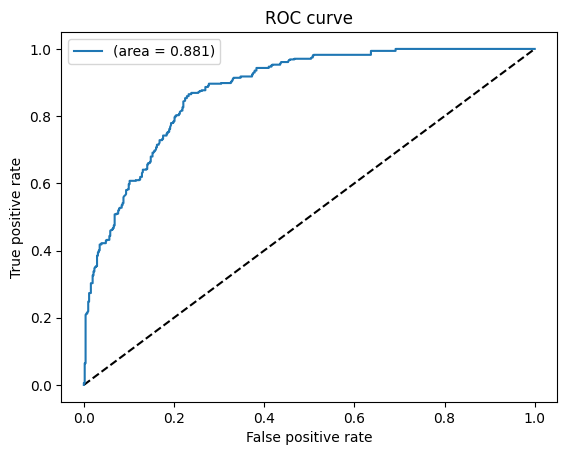

,tags,post1,post2,replies_counts,reblogs_counts,pred,labels,diff
0,b'security security',"got yet another notice from a company that ""yo...",did you know that #privacy is about more than ...,0,0,0.982684,1.0,0.017316
1,b'security snow',"got yet another notice from a company that ""yo...","oh, hey there, , we remember you! #boston #ros...",0,0,0.479007,0.0,-0.479007
2,b'NowPlaying NowPlaying',🔊 on bbc6music:#tomravenscroft - with star fe...,kings os leon ~\ncamaro#np youtube watch. cam...,0,0,0.675310,1.0,0.324690
3,b'NowPlaying book',🔊 #nowplaying on bbc6music:#tomravenscroft - w...,accidentally made best friend realize that she...,0,0,0.277732,0.0,-0.277732
4,b'nowspinning nowspinning',it was this album that really got me into cour...,it was this album that really got me into cour...,0,0,0.981398,1.0,0.018602
...,...,...,...,...,...,...,...,...
1019,b'vinyl art',it was this album that really got me into cour...,"rowan atkinson, the beloved mr. bean, is 68 ye...",0,0,0.620430,0.0,-0.620430
1020,b'weather weather',53 rivers in california will flood by tuesday;...,53 rivers in california will flood by tuesday;...,0,1,0.958981,1.0,0.041019
1021,b'weather ArtMatters',53 rivers in california will flood by tuesday;...,#sunset #cappadocia #turkey #landscapephotogra...,0,1,0.745607,0.0,-0.745607
1022,b'FollowFriday FollowFriday',don't wait to get these #free #ebooks from som...,just stumbled across that one of my favourite ...,0,0,0.928137,1.0,0.071863


In [17]:
#@title Evaluate
import itertools
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import pandas as pd
import matplotlib.pyplot as plt

import math

tf.debugging.disable_traceback_filtering()

def sigmoid(x):
  return 1 / (1 + math.exp(-x))
sigmoid_v = np.vectorize(sigmoid)

#model.load_weights('random_weights.h5')
posts = itertools.islice(iterate_posts(), 1024)
posts_by_hashtag = build_posts_by_tag(posts)
density_and_tags = build_density_and_tags(posts_by_hashtag)
x_features, labels = build_examples(1024, posts_by_hashtag, density_and_tags)

pred = sigmoid_v(model.predict(x_features))

fpr, tpr, thresholds = metrics.roc_curve(labels, pred)
auc = metrics.auc(fpr, tpr)

# Sanity check...
accuracy = 1 - np.sum(np.abs(np.round(pred) - np.array(labels).reshape(-1, 1))) / len(labels)
print('Accuracy: %f' % accuracy)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='(area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

diff = np.array(labels).reshape((-1, 1)) - pred.reshape((-1, 1))
df = pd.DataFrame(x_features)
df['pred'] = pred
df['labels'] = labels
df['diff'] = diff
df